# ART Targeted Universal Perturbation
Train a PyTorch classifier on MNIST dataset, then attack it with targeted universal adversarial perturbations.


In [5]:
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

from art.attacks.evasion import TargetedUniversalPerturbation
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

import time

Load the MNIST dataset

In [6]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Swap axes to PyTorch's NCHW format
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

Create the model and train the ART classifier

In [7]:
model = nn.Sequential(
    nn.Conv2d(1, 4, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(4, 10, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(4 * 4 * 10, 100),
    nn.Linear(100, 10),
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10
)

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=5)

Run Targeted Universal Perturbation attack

In [30]:
# Create a one-hot encoded target label array, specifying a specific class as the target for the attack
TARGET = 0
y_target = np.zeros([len(x_train), 10])
for i in range(len(x_train)):
    y_target[i, TARGET] = 1.0

attack = TargetedUniversalPerturbation(
    classifier,
    max_iter=1,
    attacker="fgsm",
    attacker_params={"delta": 0.6, "eps": 0.01, "targeted": True, "verbose": False},
)

start_time = time.time()
x_train_adv = attack.generate(x_train, y=y_target)
print("Executed in:", round((time.time()-start_time)/60, 2), "minutes")

Executed in: 2.46 minutes


Print attack statistics

In [31]:
print("Attack statistics:")
print(f"Fooling rate: {attack.fooling_rate:.2%}")
print(f"Targeted success rate: {attack.targeted_success_rate:.2%}")
print(f"Converged: {attack.converged}")

# Evaluate the attack results
train_y_pred = np.argmax(classifier.predict(x_train_adv), axis=1)
print("\nMisclassified train samples:", np.sum(np.argmax(y_train, axis=1) != train_y_pred))

# Generate adversarial examples for test set
x_test_adv = x_test + attack.noise

# Evaluate the attack results on the test set
test_y_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
print("Misclassified test samples:", len(x_test_adv[np.argmax(y_test, axis=1) != test_y_pred]))

Attack statistics:
Fooling rate: 87.79%
Targeted success rate: 97.41%
Converged: False

Misclassified train samples: 52728
Misclassified test samples: 8632


Plot some misclassified samples

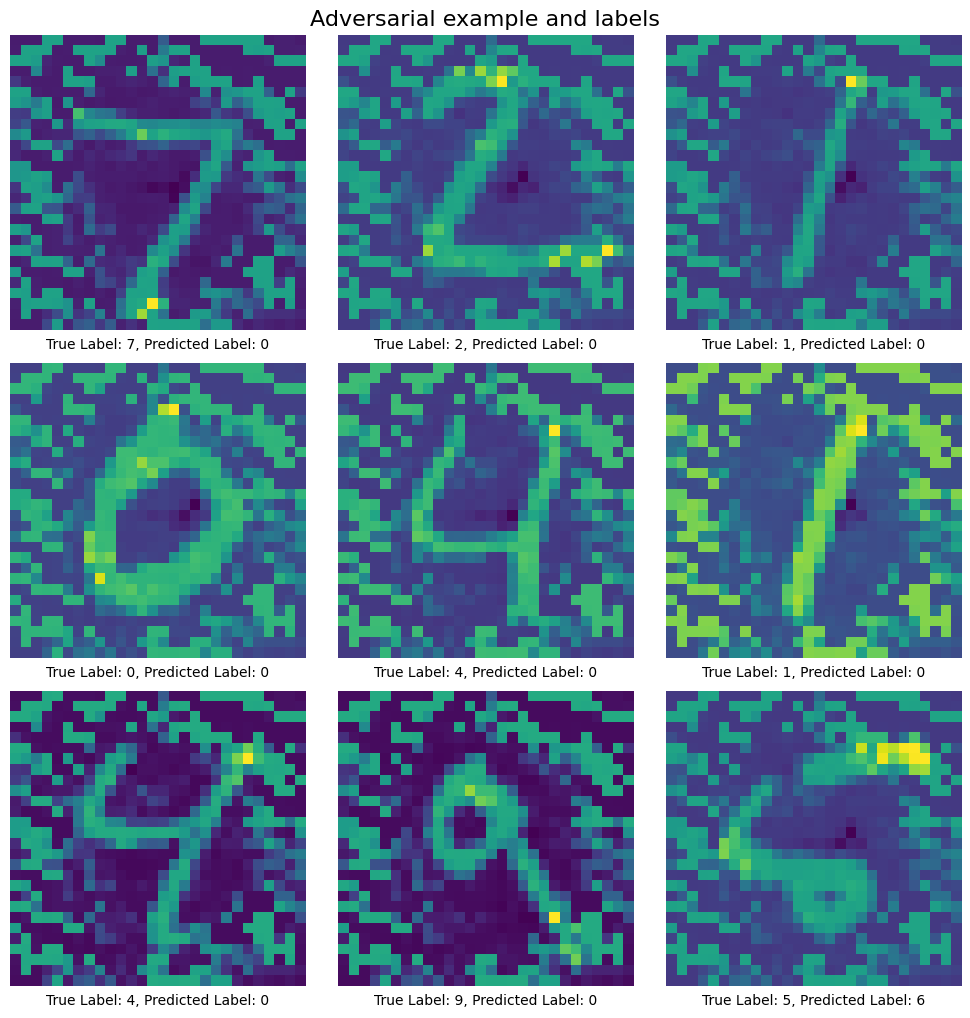

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(x_test_adv[i, ...].squeeze())
    ax.axis("off")
    ax.text(
        0.5,
        -0.05,
        f"True Label: {np.argmax(y_test, axis=1)[i]}, Predicted Label: {test_y_pred[i]}",
        transform=ax.transAxes,
        horizontalalignment="center",
        verticalalignment="center",
    )

plt.tight_layout()
plt.suptitle("Adversarial example and labels", fontsize=16, y=1.01)
plt.show()